In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.laplace import Laplace
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import  tqdm
import seaborn as sns
import pickle as pkl
from pathlib import Path

DEVICE = torch.device("cuda:3")


In [2]:
torch.cuda.is_available()

True

## Downloading and pre-processing the CIFAR10 data

In [ ]:
DATA_ROOT = Path('../data')

In [3]:
P_VIS = 1 # percent of total images per class visible

In [4]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                       download=True, transform=transform)

trainset_len = len(trainset)

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
DTHRESH = int(P_VIS*len(trainset)) 
trainset.data = trainset.data[:DTHRESH]
trainset.targets = trainset.targets[:DTHRESH]

In [6]:
np.bincount(trainset.targets) / max(np.bincount(trainset.targets))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


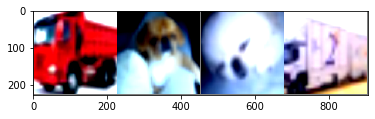

truck   dog   dog truck


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))

In [9]:
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(512, len(CLASSES))
net.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## Implementing Thresholdout & Test Routines

In [11]:
class Thresholdout:
    def __init__(self, train, holdout, tolerance=0.01/4, scale_factor=4):
        self.tolerance = tolerance
        
        self.laplace_eps = Laplace(torch.tensor([0.0]), torch.tensor([2*self.tolerance]))
        self.laplace_gamma = Laplace(torch.tensor([0.0]), torch.tensor([4*self.tolerance]))
        self.laplace_eta = Laplace(torch.tensor([0.0]), torch.tensor([8*self.tolerance]))

        self.train = train
        self.holdout = holdout
        
        self.T = 4*tolerance + self.noise(self.laplace_gamma)
        
    def noise(self, dist):
        return dist.sample().item()
        
    def verify_statistic(self, phi):
        """
            - phi(dataset) -> statistic: 
              function returns the average of some statistic
        """
        
        train_val = phi(self.train)
        holdout_val = phi(self.holdout)
                
        delta = abs(train_val - holdout_val)
        
        if delta > self.T + self.noise(self.laplace_eta):
            self.T += self.noise(self.laplace_gamma)
            return holdout_val + self.noise(self.laplace_eps), delta, False
        else:
            return train_val, delta, True


In [12]:
tout = Thresholdout(trainloader, testloader)

In [13]:
def test_accuracy(data_loader): # phi
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(DEVICE), data[1]
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total
    

In [14]:
%time test_accuracy(testloader)

CPU times: user 1min 13s, sys: 6.55 s, total: 1min 20s
Wall time: 20.3 s


0.0979

In [15]:
tout.verify_statistic(test_accuracy)

(0.0984, 0.0005000000000000004, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


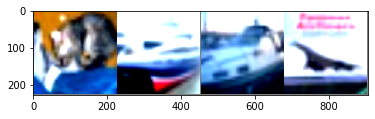

GroundTruth:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))

In [17]:
outputs = net(images.to(DEVICE))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % CLASSES[predicted[j]]
                              for j in range(4)))

Predicted:  horse plane horse horse


## Training

In [ ]:
experiment = dict()
GLOB_STEP = 0
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in tqdm(enumerate(trainloader, 0),total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        GLOB_STEP += 1
        if i % 1000 == 0 and i:    # print every 2000 mini-batches
            experiment[GLOB_STEP] = tout.verify_statistic(test_accuracy)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.090
[1,  2000] loss: 1.884
[1,  3000] loss: 1.778
[1,  4000] loss: 1.696
[1,  6000] loss: 1.482
[1,  7000] loss: 1.369
[1,  8000] loss: 1.324
[1,  9000] loss: 1.256
[1, 10000] loss: 1.201
[1, 11000] loss: 1.173
[1, 12000] loss: 1.111



[2,  1000] loss: 1.031
[2,  2000] loss: 1.009
[2,  3000] loss: 0.965
[2,  4000] loss: 0.940
[2,  5000] loss: 0.924
[2,  6000] loss: 0.906
[2,  7000] loss: 0.946
[2,  8000] loss: 0.894
[2,  9000] loss: 0.835
[2, 10000] loss: 0.838
[2, 11000] loss: 0.821
[2, 12000] loss: 0.813



[3,  1000] loss: 0.771
[3,  2000] loss: 0.718
[3,  3000] loss: 0.723
[3,  4000] loss: 0.738
[3,  5000] loss: 0.713
[3,  6000] loss: 0.700
[3,  7000] loss: 0.699
[3,  8000] loss: 0.713
[3,  9000] loss: 0.666
[3, 10000] loss: 0.660
[3, 11000] loss: 0.655
[3, 12000] loss: 0.672



[4,  1000] loss: 0.571
[4,  2000] loss: 0.580
[4,  3000] loss: 0.582
[4,  4000] loss: 0.583
[4,  5000] loss: 0.569
[4,  6000] loss: 0.540
[4,  7000] loss: 0.576
[4,  8000] loss: 0.577
[4,  9000] loss: 0.555
[4, 10000] loss: 0.565
[4, 11000] loss: 0.557
[4, 12000] loss: 0.544



[5,  1000] loss: 0.444
[5,  2000] loss: 0.446
[5,  3000] loss: 0.468
[5,  4000] loss: 0.455
[5,  5000] loss: 0.479
[5,  6000] loss: 0.468
[5,  7000] loss: 0.476
[5,  8000] loss: 0.472
[5,  9000] loss: 0.441
[5, 10000] loss: 0.455
[5, 11000] loss: 0.479
[5, 12000] loss: 0.453



[6,  1000] loss: 0.350
[6,  2000] loss: 0.338
[6,  3000] loss: 0.370
[6,  4000] loss: 0.384
[6,  5000] loss: 0.353
[6,  6000] loss: 0.383
[6,  7000] loss: 0.382
[6,  8000] loss: 0.376
[6,  9000] loss: 0.388
[6, 10000] loss: 0.368
[6, 11000] loss: 0.365
[7,  1000] loss: 0.283
[7,  2000] loss: 0.285
[7,  3000] loss: 0.286
[7,  4000] loss: 0.283
[7,  5000] loss: 0.278
[7,  6000] loss: 0.282
[7,  7000] loss: 0.298
[7,  8000] loss: 0.308
[7,  9000] loss: 0.307
[7, 10000] loss: 0.313
[7, 11000] loss: 0.294
[7, 12000] loss: 0.297



[8,  1000] loss: 0.188
[8,  2000] loss: 0.217
[8,  3000] loss: 0.197
[8,  4000] loss: 0.214
[8,  5000] loss: 0.247
[8,  6000] loss: 0.242
[8,  7000] loss: 0.235
[8,  8000] loss: 0.234
[8,  9000] loss: 0.202
[8, 10000] loss: 0.227
[8, 11000] loss: 0.246
[8, 12000] loss: 0.238



[9,  1000] loss: 0.125
[9,  2000] loss: 0.144
[9,  3000] loss: 0.175
[9,  4000] loss: 0.170
[9,  5000] loss: 0.175
[9,  6000] loss: 0.171
[9,  7000] loss: 0.174


In [ ]:
experiment

In [ ]:
with open('new-resnet-data-p1.pkl','wb') as fp: pkl.dump(experiment, fp)